# Magnetic Field: Forward Modelling
This code is based on the following tutorial of the ***Fatiando*** project:

[Rectangular Prisms - Magnetic Fields | Harmonica](https://www.fatiando.org/harmonica/latest/user_guide/forward_modelling/prism.html#magnetic-fields)

The Digital Terrain Models are taken from platforms such as [Colombia en Mapas](https://www.colombiaenmapas.gov.co/inicio/)

In [1]:
%matplotlib inline
from IPython.display import display, Math

In [2]:
import verde as vd
import xarray as xr
import numpy as np
import harmonica as hm
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
from matplotlib.colors import LinearSegmentedColormap

In [3]:
cmap_terrain = plt.get_cmap('terrain')

cmap_terrain_crust = LinearSegmentedColormap.from_list(
    'terrain_crust', cmap_terrain(np.linspace(0.25, 0.75, 256))
)

### 1. Digital Terrain Model for measurement or prism difinition 

In [4]:
filename = '../data/Sopetran_DTM.tif' # DTM taken from colombiaenmapas.gov.co
topography = xr.load_dataset(filename, engine="rasterio")
topography = topography.sortby(['x', 'y'])

region = (4.697e6, 4.703e6, 2.279e6, 2.285e6)
topography_domain = topography.sel(
    x=slice(*region[:2]),
    y=slice(*region[2:]),
)

sampling = 10
topography_domain_subsampled = topography_domain.isel(
    x=slice(None, None, sampling),
    y=slice(None, None, sampling)
)

surface = topography_domain_subsampled.band_data[0, :, :]
surface = surface.fillna(0)

density = 2670.0 * np.ones_like(surface)
density = np.where(surface >= 0, density, 1000 - 2900)

spacing = 20
reduction = 2000
region_ROI = tuple(val + reduction if i % 2 == 0 else val - reduction for i, val in enumerate(region))

coordinates_ROI = vd.grid_coordinates(region=region_ROI, spacing=spacing)

x = topography_domain_subsampled.x
y = topography_domain_subsampled.y
surface_interpolated = RectBivariateSpline(x, y, surface.T)
surface_ROI = surface_interpolated.ev(coordinates_ROI[0], coordinates_ROI[1])

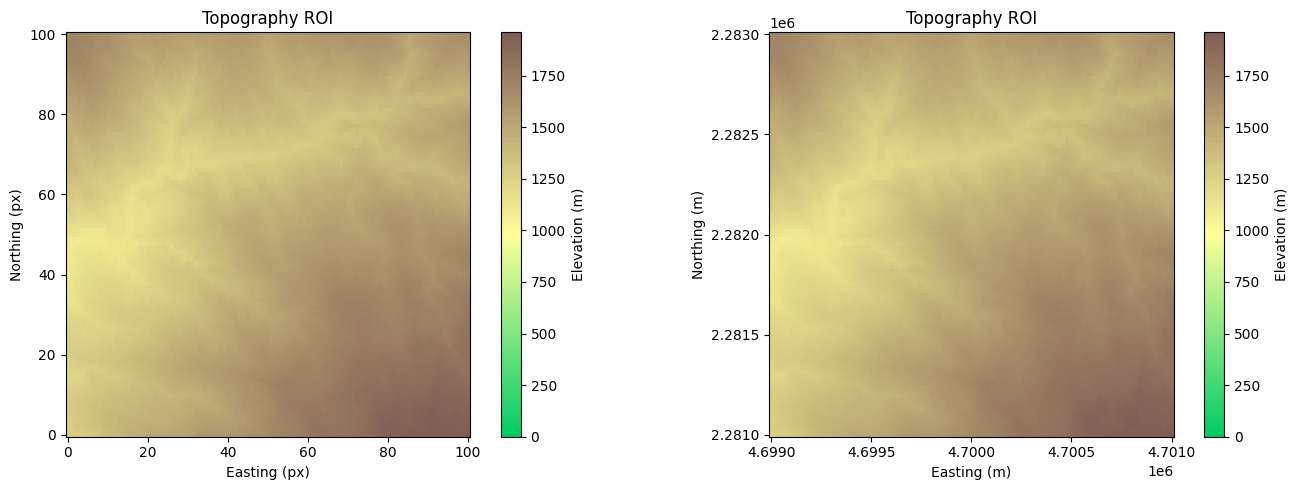

In [5]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 5))
im0 = ax0.imshow(surface_ROI, cmap=cmap_terrain_crust, origin='lower', vmin=0)
plt.colorbar(im0, ax=ax0, label="Elevation (m)")
ax0.set_title("Topography ROI")
ax0.set_xlabel("Easting (px)")
ax0.set_ylabel("Northing (px)")
ax0.set_aspect("equal")
ax0.locator_params(axis='x', nbins=6)
ax0.locator_params(axis='y', nbins=6)

im1 = ax1.pcolormesh(coordinates_ROI[0], coordinates_ROI[1], surface_ROI, cmap=cmap_terrain_crust, vmin=0)
plt.colorbar(im1, ax=ax1, label="Elevation (m)")
ax1.set_title("Topography ROI")
ax1.set_xlabel("Easting (m)")
ax1.set_ylabel("Northing (m)")
ax1.set_aspect("equal")
ax1.locator_params(axis='x', nbins=5)
ax1.locator_params(axis='y', nbins=5)

plt.tight_layout()

plt.show()

### 2. Create prisms
#### 2.1 Using the DTM

In [ ]:
# prisms = hm.prism_layer(
#     coordinates=(x, y),
#     surface=surface,
#     reference=0,
#     properties={"density": density},
# )
# prisms_number = prisms.prism_layer.size
# prisms_number

90000

In [ ]:
# prisms = prisms.prism_layer._to_prisms()
# prisms[:, 5] += -100
# magnetization_easting =  0.5*np.ones(prisms_number)
# magnetization_northing = -0.25*np.ones(prisms_number)
# magnetization_upward = -0.78989*np.ones(prisms_number)

#### 2.2 Manually defining each one

In [16]:
prisms = [
    [4700500, 4700550, 2282700, 2282750, -0.5e4, 700],
    [4699950, 4700000, 2281950, 2282000, -0.5e4, 700]
]

magnetization_easting = np.array([0.5, 0.5])
magnetization_northing = np.array([0.5, -0.5])
magnetization_upward = np.array([-0.78989, 0.8])

#### Magnetization vector

In [17]:
magnetization = (
   magnetization_easting, magnetization_northing, magnetization_upward
)

### 3. Measurement coordinates

In [18]:
extra_coords = 1000 * np.ones_like(coordinates_ROI[0])
#extra_coords = surface_ROI + 10

### 4. Magnetic Field Forward Modelling

Calculate the magnetic fields generated by rectangular prisms on a set of observation points

In [19]:
b_e, b_n, b_u = hm.prism_magnetic((coordinates_ROI[0], coordinates_ROI[1], extra_coords), prisms, magnetization, field="b")
b = np.sqrt(b_e**2 + b_n**2 + b_u**2)
b_e

array([[-0.07940407, -0.08192096, -0.08446907, ...,  0.05230992,
         0.05141257,  0.05048028],
       [-0.08056719, -0.08318732, -0.08584352, ...,  0.05441179,
         0.05341142,  0.0523784 ],
       [-0.08171431, -0.08444079, -0.08720858, ...,  0.05655408,
         0.05544439,  0.05430475],
       ...,
       [ 0.06921984,  0.07024462,  0.07129075, ..., -0.31485132,
        -0.29496506, -0.27620362],
       [ 0.06805219,  0.06903354,  0.07003446, ..., -0.2996658 ,
        -0.28110156, -0.26354597],
       [ 0.06682483,  0.06776076,  0.06871436, ..., -0.28514938,
        -0.26782892, -0.25141077]], shape=(101, 101))

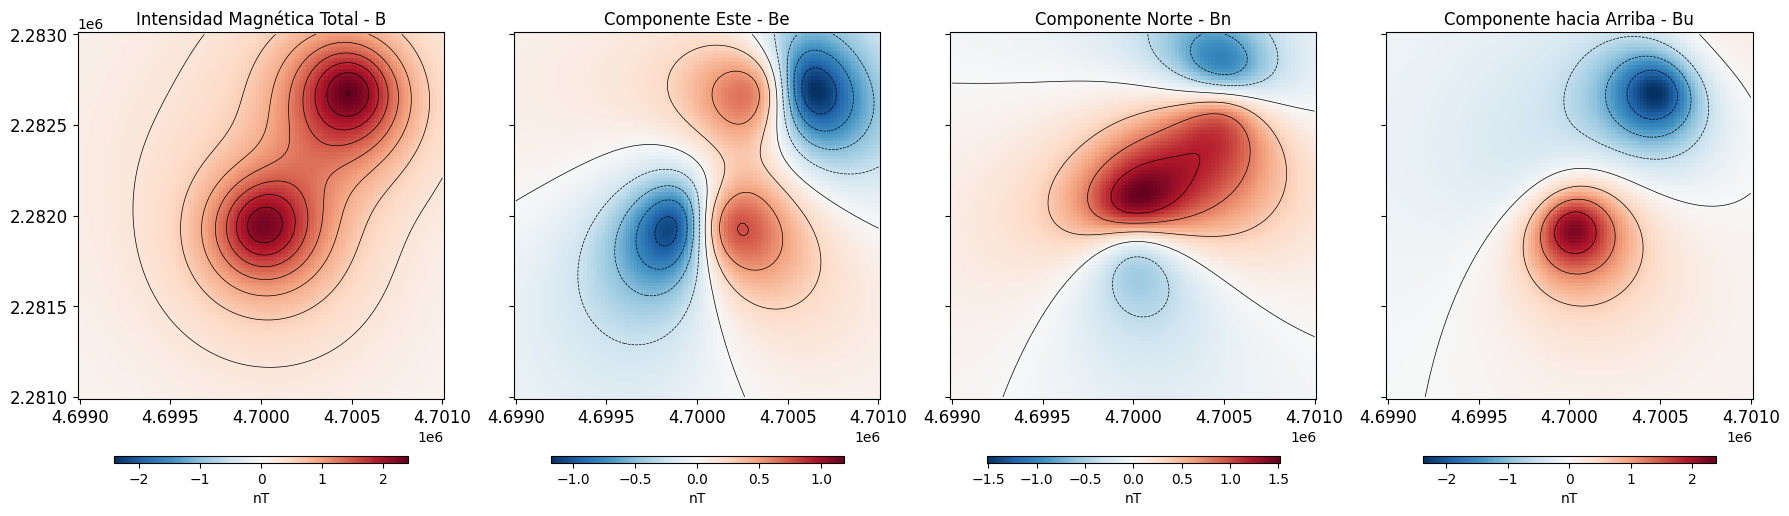

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(18, 6))

for ax, mag_component, title in zip(axes, (b, b_e, b_n, b_u), ("Intensidad Magnética Total - B", "Componente Este - Be", "Componente Norte - Bn", "Componente hacia Arriba - Bu")):
    maxabs = vd.maxabs(mag_component)
    tmp = ax.pcolormesh(
        coordinates_ROI[0],
        coordinates_ROI[1],
        mag_component,
        vmin=-maxabs,
        vmax=maxabs,
        cmap="RdBu_r",
    )
    ax.contour(
        coordinates_ROI[0],
        coordinates_ROI[1],
        mag_component,
        colors="k",
        linewidths=0.5,
    )
    ax.set_title(title)
    ax.set_aspect("equal")
    ax.locator_params(axis='y', nbins=5)
    ax.locator_params(axis='x', nbins=5)
    ax.tick_params(axis='both', which='major', labelsize=12)

    plt.colorbar(
        tmp,
        ax=ax,
        orientation="horizontal",
        label="nT",
        pad=0.1,
        aspect=42,
        shrink=0.8,
    )
plt.tight_layout()
plt.savefig('../output/figures/forward_modeling_magnetic_prisms.png', dpi=300)
plt.show()